In [90]:
%pylab inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision.transforms import ToTensor, Grayscale

from tqdm import trange


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [91]:
import warnings
warnings.filterwarnings('ignore')


In [92]:
BATCH=4

In [93]:
train_data = datasets.MNIST(
	root='data',
	train=True,
	transform=transforms.Compose([
		ToTensor(),
		# Grayscale(1),
		# transforms.Normalize((0.1307,), (0.3081,)),
	]),
	download=True,
);

trainloader = torch.utils.data.DataLoader(
	train_data,
	batch_size=BATCH,
	num_workers=12,
	shuffle=True
)

In [94]:
for data in trainloader:
	print(data[0].shape)
	break

torch.Size([4, 1, 28, 28])


In [95]:
class G(nn.Module):
	def __init__(self):
		super(G, self).__init__()

		self.deconvs = nn.Sequential(
			nn.ConvTranspose2d(1, 24, 3),
			nn.ReLU(inplace=True),

			nn.ConvTranspose2d(24, 32, 3),
			nn.ReLU(inplace=True),

			nn.ConvTranspose2d(32, 40, 3),
			nn.ReLU(inplace=True),

			nn.ConvTranspose2d(40, 1, 3),
		)

	def forward(self, x):
		x = self.deconvs(x)

		return x

noise shape: torch.Size([4, 1, 20, 20])
out shape: torch.Size([4, 1, 28, 28])
out 0 shape: torch.Size([1, 28, 28])


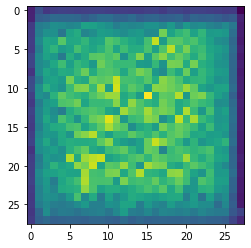

In [96]:
generator = G()

noise = torch.randn(BATCH, 1, 20, 20)
print('noise shape:', noise.shape)

out = generator(noise)

print('out shape:', out.shape)
print('out 0 shape:', out[0].shape)

imshow(out[0].reshape(28, 28).detach())

In [140]:
class D(nn.Module):
	def __init__(self):
		super(D, self).__init__()

		self.convs = nn.Sequential(
			nn.Conv2d(1, 16, 3),
			nn.BatchNorm2d(16),
			nn.LeakyReLU(inplace=True),

			nn.Conv2d(16, 32, 3),
			nn.BatchNorm2d(32),
			nn.LeakyReLU(inplace=True),

			nn.Conv2d(32, 64, 3),
			nn.BatchNorm2d(64),
			nn.Sigmoid(),
		)

		self.classifier = nn.Linear(64 * 22 * 22, 1)

	def forward(self, x):
		x = self.convs(x)

		x = x.reshape(x.shape[0], -1)

		x = self.classifier(x)

		return x

In [141]:
generator = G()
discriminator = D()

In [145]:
loss_fn = nn.BCEWithLogitsLoss()

g_optim = optim.Adam(generator.parameters(), lr=3e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=3e-4)

EPOCHS = 10

In [146]:
for epoch in trange(EPOCHS):
	for i, data in enumerate(trainloader):
		print(i)
		images = data[0]

		g_optim.zero_grad()
		d_optim.zero_grad()

		dis_out_real = discriminator(images)
		error_real = loss_fn(dis_out_real, torch.ones(BATCH, 1))
		error_real.backward()

		noise = torch.randn(BATCH, 1, 20, 20)
		
		generated = generator(noise)

		dis_out_fake = discriminator(generated)
		error_fake = loss_fn(dis_out_fake, torch.zeros(BATCH, 1))
		error_fake.backward()

		dis_loss = (error_real.item() + error_fake.item()) / 2

		g_optim.step()

		





  0%|          | 0/10 [00:00<?, ?it/s]

0
tensor([[0.2142],
        [0.0845],
        [0.2612],
        [0.2021]], grad_fn=<AddmmBackward>)
1
tensor([[0.1020],
        [0.1996],
        [0.1577],
        [0.1574]], grad_fn=<AddmmBackward>)
2
tensor([[0.2652],
        [0.1760],
        [0.2269],
        [0.2325]], grad_fn=<AddmmBackward>)
3
tensor([[0.1710],
        [0.0695],
        [0.1688],
        [0.1620]], grad_fn=<AddmmBackward>)
4
tensor([[0.2351],
        [0.0327],
        [0.2368],
        [0.2542]], grad_fn=<AddmmBackward>)
5
tensor([[0.1322],
        [0.2222],
        [0.1055],
        [0.2237]], grad_fn=<AddmmBackward>)
6
tensor([[0.2058],
        [0.2150],
        [0.3129],
        [0.2393]], grad_fn=<AddmmBackward>)
7
tensor([[0.2997],
        [0.2428],
        [0.3779],
        [0.1630]], grad_fn=<AddmmBackward>)
8
tensor([[ 0.1800],
        [ 0.1710],
        [-0.0276],
        [ 0.3002]], grad_fn=<AddmmBackward>)
9
tensor([[0.2198],
        [0.1733],
        [0.2897],
        [0.2324]], grad_fn=<AddmmBackwar

  0%|          | 0/10 [00:08<?, ?it/s]


KeyboardInterrupt: 